In [1]:
!unzip -q Composer_Dataset.zip

In [2]:
!pip install pretty_midi
!pip install mido librosa
import pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=fd4665fb031e370f34dff5cda82c9433d2cd470faa8392ebd0bccdab10d7f8f3
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [30]:
import os
import numpy as np
import pretty_midi
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns



 ## 2. Data Pre-processing

### Function: `get_fixed_piano_roll()`

This function reads a MIDI file and converts it into a fixed-size **piano roll** matrix. This format is well-suited for training deep learning models like CNNs.

**What is a piano roll?**
- A 2D matrix representing music over time
- **Rows (0–127)** → MIDI pitches (piano notes)
- **Columns** → Time steps
- **Values** → Note velocity (intensity) at each time step

**Purpose of this function:**
- Converts symbolic MIDI files into a structured numeric format
- Ensures each sample has the same time dimension (`max_time_steps`)
  - Short files are **padded** with zeros
  - Long files are **truncated**

**Piano Roll Matrix**

The piano roll is a 128 × 1200 matrix where:

Each row corresponds to a MIDI pitch (0–127)

Each column represents a fixed time step (e.g., 10ms if fs=100)

Each cell stores the velocity (0–127) of a note at that pitch and time
This matrix captures the timing and intensity of notes and serves as input to d CNN model.

In [10]:
import os
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt

# ---- Function to convert MIDI file to piano roll ----
def get_fixed_piano_roll(midi_path, max_time_steps=1200, fs=20):
    try:
        original_midi = pretty_midi.PrettyMIDI(midi_path)

        # Find earliest note start time
        start_time = min(
            (note.start for inst in original_midi.instruments for note in inst.notes),
            default=0
        )

        # Shift notes so the earliest starts near time 0
        new_midi = pretty_midi.PrettyMIDI()
        for inst in original_midi.instruments:
            if inst.is_drum or len(inst.notes) == 0:
                continue
            new_inst = pretty_midi.Instrument(program=inst.program, is_drum=False, name=inst.name)
            for note in inst.notes:
                note.start -= start_time
                note.end -= start_time
                new_inst.notes.append(note)
            new_midi.instruments.append(new_inst)

        # Convert to piano roll
        pr = new_midi.get_piano_roll(fs=fs)
        pr = pr[:, :max_time_steps] if pr.shape[1] >= max_time_steps else np.pad(
            pr, ((0, 0), (0, max_time_steps - pr.shape[1])), mode='constant'
        )
        pr = np.clip(pr, 0, 127)
        return pr
    except Exception as e:
        print(f"Skipped {midi_path}: {e}")
        return None

**debug_midi_file(midi_path)**

This function prints basic information about a MIDI file, including:

The number of instruments

Whether each instrument is a drum or not

The number of notes in each instrument

The start time of the first note
It helps identify empty or unusual MIDI files during preprocessing.



In [11]:
# ---- Function to print debug info for a MIDI file ----
def debug_midi_file(midi_path):
    """
    Prints key details about the MIDI file:
    - File name
    - Number of instruments
    - Note count and first note start time for each instrument
    """
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)
        print(f"\n🎼 MIDI File: {midi_path}")
        print(f"Total instruments: {len(midi.instruments)}")
        for i, inst in enumerate(midi.instruments):
            print(f"  ▶ Instrument {i+1}: {'Drums' if inst.is_drum else inst.name or 'Unnamed'}")
            if inst.notes:
                print(f"     Notes: {len(inst.notes)} | First note starts at: {inst.notes[0].start:.2f} sec")
            else:
                print("     Notes: 0")
    except Exception as e:
        print(f"Could not read {midi_path}: {e}")


This block does the following:

1. **Searches for MIDI files** inside `Composer_Dataset` (including subfolders)
2. **Displays metadata** for the first 3 MIDI files:
   - Number of instruments
   - Number of notes
   - Start time of the first note
3. **Converts each MIDI file to a piano roll** (a 128×1200 matrix):
   - Rows = MIDI pitches (0–127)
   - Columns = time steps
   - Values = note velocity (0–127)
4. **Prints a small slice** of pitches 60–69 and time steps 0–20
5. **Visualizes the piano roll** as a heatmap (limited to pitch range 40–90)

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(



🎼 MIDI File: Composer_Dataset/NN_midi_files_extended/dev/mozart/mozart035.mid
Total instruments: 2
  ▶ Instrument 1: Mozart
     Notes: 1689 | First note starts at: 1.55 sec
  ▶ Instrument 2: Sonata # 16
     Notes: 581 | First note starts at: 1.55 sec
Piano Roll Shape: (128, 1200)
Non-zero entries: 2131

Sample (pitches 60–69 × time steps 0–20):
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [79.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. 79.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

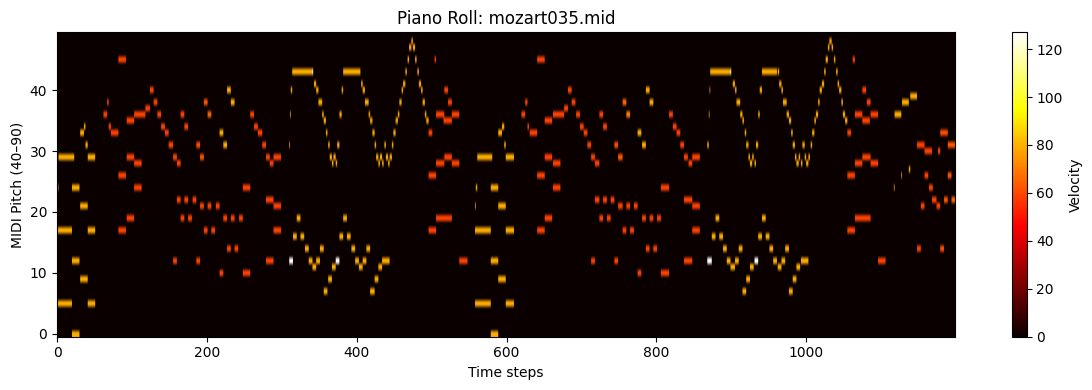


🎼 MIDI File: Composer_Dataset/NN_midi_files_extended/dev/mozart/mozart020.mid
Total instruments: 4
  ▶ Instrument 1: Mozart - Piano
     Notes: 3423 | First note starts at: 122.02 sec
  ▶ Instrument 2: Concerto  #15
     Notes: 1562 | First note starts at: 2.02 sec
  ▶ Instrument 3: K450 -a -Allegro
     Notes: 2177 | First note starts at: 1.50 sec
  ▶ Instrument 4: Midi by: 
     Notes: 1719 | First note starts at: 2.02 sec
Piano Roll Shape: (128, 1200)
Non-zero entries: 3917

Sample (pitches 60–69 × time steps 0–20):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

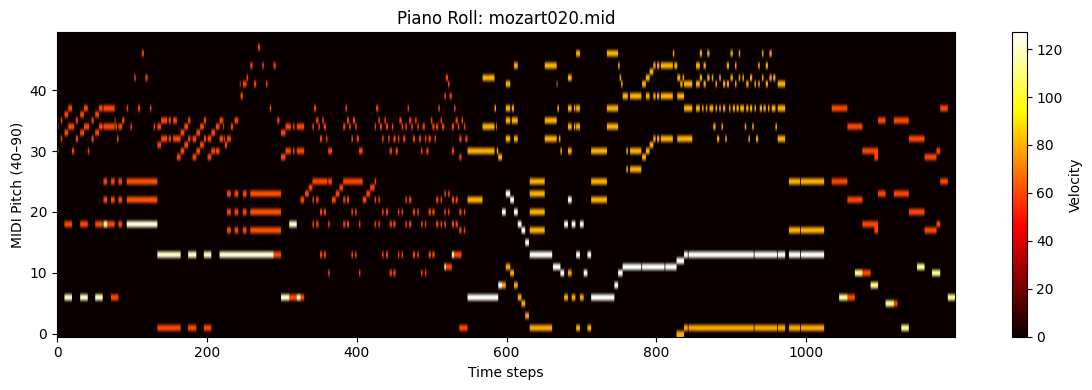


🎼 MIDI File: Composer_Dataset/NN_midi_files_extended/dev/mozart/mozart039.mid
Total instruments: 2
  ▶ Instrument 1: Mozart
     Notes: 2376 | First note starts at: 0.52 sec
  ▶ Instrument 2: K311-c-Rondo-Allegro
     Notes: 1117 | First note starts at: 5.62 sec
Piano Roll Shape: (128, 1200)
Non-zero entries: 1843

Sample (pitches 60–69 × time steps 0–20):
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 60. 60. 60. 60.
  60. 60.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 60. 60. 60. 60.
  60. 60.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

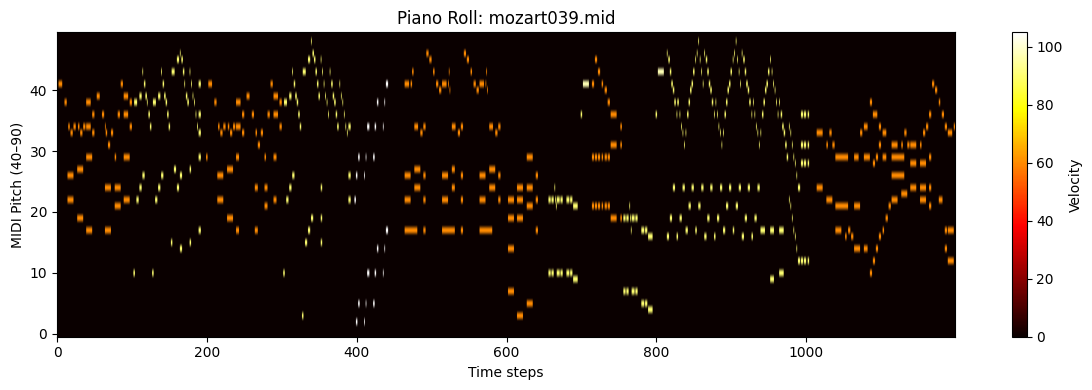

In [12]:
# ---- Locate all MIDI files from nested subfolders ----
midi_folder = "Composer_Dataset"
midi_files = []

# Walk through all subdirectories and collect paths to .mid or .midi files
for root, _, files in os.walk(midi_folder):
    for file in files:
        if file.endswith(".mid") or file.endswith(".midi"):
            midi_files.append(os.path.join(root, file))

# ---- Inspect and visualize the first 3 MIDI files ----
for idx, midi_path in enumerate(midi_files[:3]):
    # Print basic info about the MIDI file
    debug_midi_file(midi_path)

    # Convert the MIDI to a fixed-size piano roll
    piano_roll = get_fixed_piano_roll(midi_path)

    if piano_roll is not None:
        # Print shape and how many non-zero values exist in the roll
        print(f"Piano Roll Shape: {piano_roll.shape}")
        print(f"Non-zero entries: {np.count_nonzero(piano_roll)}")

        # Print a portion of the piano roll in the musically active range (Middle C and surrounding)
        print("\nSample (pitches 60–69 × time steps 0–20):")
        print(np.round(piano_roll[60:70, :20], decimals=1))

        # Visualize the piano roll (limited to pitch range 40–90)
        plt.figure(figsize=(12, 4))
        plt.imshow(piano_roll[40:90, :], aspect='auto', cmap='hot', origin='lower')
        plt.title(f"Piano Roll: {os.path.basename(midi_path)}")
        plt.xlabel("Time steps")
        plt.ylabel("MIDI Pitch (40–90)")
        plt.colorbar(label="Velocity")
        plt.tight_layout()
        plt.show()



## process_and_save_all()
This function processes all MIDI files organized by composer (e.g., Bach, Mozart) in subfolders.

- Converts each MIDI file into a fixed-size piano roll matrix (`128 × 1200`)
- Saves the matrix as a `.npy` file for fast loading
- Records each file path and its composer label in a CSV file

Ready for CNN Model



In [13]:
def process_and_save_all(mid_root, save_dir, csv_path):
    os.makedirs(save_dir, exist_ok=True)
    rows = []
    for composer in sorted(os.listdir(mid_root)):
        comp_dir = os.path.join(mid_root, composer)
        if not os.path.isdir(comp_dir): continue
        for fname in os.listdir(comp_dir):
            if not fname.lower().endswith(('.mid', '.midi')): continue
            full_path = os.path.join(comp_dir, fname)
            piano_roll = get_fixed_piano_roll(full_path)
            if piano_roll is not None:
                save_name = f"{composer}_{fname.replace('.mid','').replace('.midi','')}.npy"
                save_path = os.path.join(save_dir, save_name)
                np.save(save_path, piano_roll)
                rows.append([save_path, composer])
    df = pd.DataFrame(rows, columns=['file_path', 'label'])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} files to {save_dir} and index to {csv_path}")

In [70]:
import pandas as pd
process_and_save_all(
    mid_root="Composer_Dataset/NN_midi_files_extended/train",
    save_dir="saved_pianorolls/train",
    csv_path="saved_pianorolls/train_index.csv"
)

Saved 369 files to saved_pianorolls/train and index to saved_pianorolls/train_index.csv


## Load and Visualize a Sample Piano Roll .npy File

Sample index entries:
                                 file_path label
0  saved_pianorolls/train/bach_bach365.npy  bach
1  saved_pianorolls/train/bach_bach366.npy  bach
2  saved_pianorolls/train/bach_bach381.npy  bach
3  saved_pianorolls/train/bach_bach373.npy  bach
4  saved_pianorolls/train/bach_bach347.npy  bach

Loading sample from index: saved_pianorolls/train/bach_bach365.npy
Piano Roll Shape: (128, 1200)
Non-zero values: 3212

Found 369 .npy files in directory.

Sample file from directory: bach_bach381.npy
Shape: (128, 1200)
Data type: float64
Non-zero entries: 2881

Sample matrix (pitches 60–69 × time steps 0–20):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

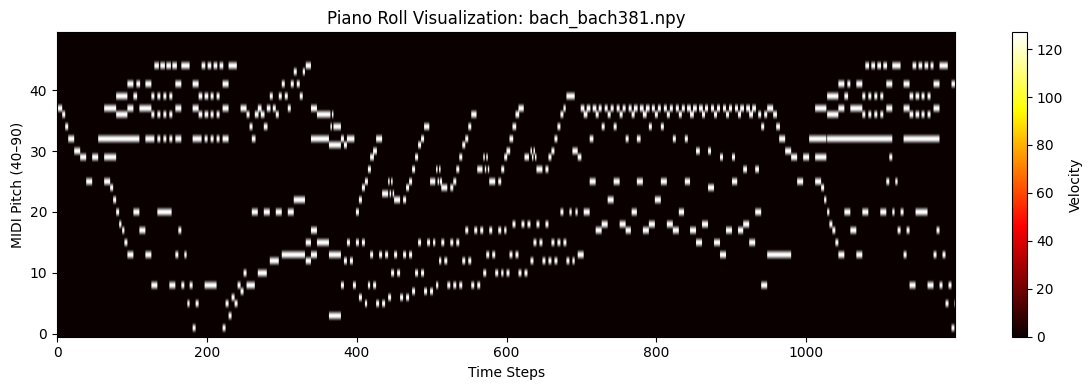

In [14]:
# --- Step 1: Load the index CSV with paths and labels ---
index_csv_path = "saved_pianorolls/train_index.csv"
index_df = pd.read_csv(index_csv_path)

# Display a few entries from the index
print("Sample index entries:")
print(index_df.head())

# --- Step 2: Load a sample .npy piano roll file from index ---
sample_index_path = index_df['file_path'].iloc[0]
print(f"\nLoading sample from index: {sample_index_path}")
piano_roll = np.load(sample_index_path)

# Display shape and summary of matrix
print("Piano Roll Shape:", piano_roll.shape)
print("Non-zero values:", np.count_nonzero(piano_roll))

# --- Step 3: List all .npy files directly from folder ---
npy_dir = "saved_pianorolls/train"
npy_files = [f for f in os.listdir(npy_dir) if f.endswith(".npy")]
print(f"\nFound {len(npy_files)} .npy files in directory.")

# Load another sample directly from file list
sample_path = os.path.join(npy_dir, npy_files[0])
piano_roll = np.load(sample_path)

# Display info
print(f"\nSample file from directory: {npy_files[0]}")
print("Shape:", piano_roll.shape)
print("Data type:", piano_roll.dtype)
print("Non-zero entries:", np.count_nonzero(piano_roll))

# --- Step 4: Show a small portion of the matrix ---
print("\nSample matrix (pitches 60–69 × time steps 0–20):")
print(np.round(piano_roll[60:70, :20], decimals=1))

# --- Step 5: Visualize the piano roll (focused pitch range) ---
plt.figure(figsize=(12, 4))
plt.imshow(piano_roll[40:90], aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label="Velocity")
plt.xlabel("Time Steps")
plt.ylabel("MIDI Pitch (40–90)")
plt.title(f"Piano Roll Visualization: {os.path.basename(sample_path)}")
plt.tight_layout()
plt.show()

## Data preparation for training a CNN model

- Loads .npy piano roll data and composer labels

- Prepares the dataset for training a CNN model

- Encodes labels numerically

- Ensures stratified splits for balanced class distribution

- Reshapes data for CNN compatibility

In [15]:
df = pd.read_csv("saved_pianorolls/train_index.csv")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=0)
unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(label_map)

df['label_idx'] = df['label'].map(label_map)

# Load piano roll data
#Loads the .npy piano roll files into memory.
#Stores them in X and their corresponding label indices in y.
X = []
y = []
for _, row in df.iterrows():
    X.append(np.load(row['file_path']))
    y.append(row['label_idx'])

X = np.array(X)
y = np.array(y)

# Reshape for CNN: add channel dimension
X = X[..., np.newaxis]  # shape becomes (samples, 128, 1200, 1)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# First split train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Now split X_temp into train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=0)
# Now: 60% train, 20% val, 20% test

**load_data(df):**

This function:

- Loads .npy piano roll arrays from the paths listed in the DataFrame.

- Converts string labels (e.g., "Mozart") to numeric IDs using label_map.

- Returns the prepared feature array X, labels array y, and the mapping used.

In [16]:
def load_data(df):
    X = []
    y = []
    label_map = {label: i for i, label in enumerate(df['label'].unique())}
    for _, row in df.iterrows():
        X.append(np.load(row['file_path']))
        y.append(label_map[row['label']])
    return np.array(X), np.array(y), label_map


## 4. Model Building

**CNN Model Without L2 Regularization**

This Convolutional Neural Network (CNN) is designed to classify piano roll representations of musical compositions into composer categories.

Input Shape: (128, 1200, 1)
Each sample represents a grayscale piano roll with 128 pitches over 1200 time steps.

**Model Architecture:**

- Conv Block 1:

  - Conv2D(32, 3x3, ReLU)
  - BatchNormalization

  - MaxPooling2D(2x2)

  - Dropout(0.25)

- Conv Block 2:

  - Conv2D(64, 3x3, ReLU)

  - BatchNormalization

  - MaxPooling2D(2x2)

  - Dropout(0.25)

- Fully Connected Layers:

  - Flatten

  - Dense(128, ReLU)

  - BatchNormalization

  - Dropout(0.5)

  - Dense(num_classes, softmax) — outputs class probabilities

**CNN Model With L2 Regularization**
**Description:**
This model uses the same CNN architecture as model without L2, but adds L2 regularization to each Conv2D and Dense layer. L2 regularization (also known as weight decay) penalizes large weights during training, encouraging the network to learn simpler and more generalizable features.

**Architecture Enhancements:**
- Adds kernel_regularizer=l2(1e-4) to:

- Both Conv2D layers

- Dense layer before the output

- Same Dropout, BatchNorm, and pooling layers as the baseline

**Benefits:**
- Helps reduce overfitting by discouraging large weight magnitudes

- Encourages a smoother decision boundary and better generalization

- Especially useful when working with limited or imbalanced datasets

In [17]:
#Model without L2 Regularization
def build_model_no_l2():
    model = Sequential([
        Input(shape=(128, 1200, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model

#Model with L2 regularization
def build_model_with_l2():
    model = Sequential([
        Input(shape=(128, 1200, 1)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model

## 5. Model Training
Optimizer: Adam

Loss Function: Sparse Categorical Crossentropy

Metric: Accuracy

Training Enhancements:

EarlyStopping: Stops training when validation loss stops improving

ModelCheckpoint: Saves the best model based on validation loss

In [18]:
def compile_and_train(model, name):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )
    return history

In [19]:
def plot_history(histories, metric):
    plt.figure(figsize=(10, 5))
    for name, hist in histories.items():
        plt.plot(hist.history[metric], label=f"{name} {metric}")
        plt.plot(hist.history[f"val_{metric}"], label=f"{name} val_{metric}")
    plt.title(f"{metric.title()} Comparison")
    plt.xlabel("Epoch")
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.show()

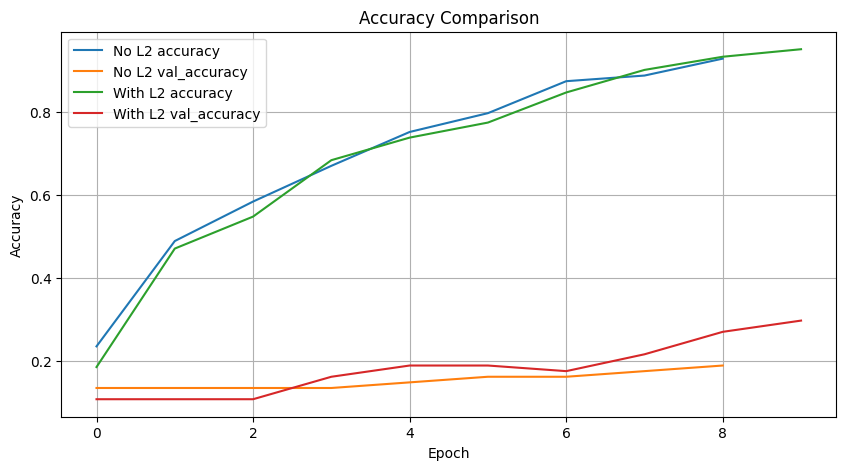

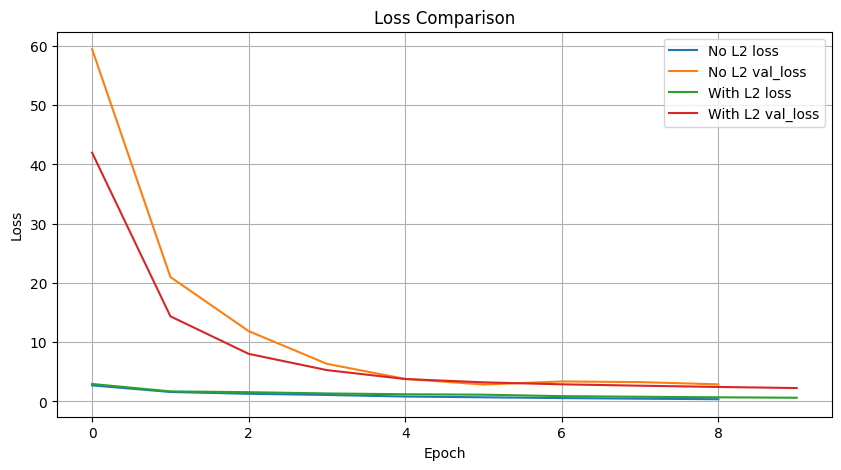

In [20]:
model_no_l2 = build_model_no_l2()
model_l2 = build_model_with_l2()

hist_no_l2 = compile_and_train(model_no_l2, "No L2")
hist_l2 = compile_and_train(model_l2, "With L2")

histories = {
    "No L2": hist_no_l2,
    "With L2": hist_l2
}

plot_history(histories, "accuracy")
plot_history(histories, "loss")

## 7. Model Optimization
## Apply Class Weight

If some composers have more files than others, Class weight helps

In [23]:
from sklearn.utils.class_weight import compute_class_weight
# Compute balanced class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 131s 18s/step - accuracy: 0.2331 - loss: 2.8084 - val_accuracy: 0.1757 - val_loss: 29.9717
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 119s 17s/step - accuracy: 0.5118 - loss: 1.4041 - val_accuracy: 0.1351 - val_loss: 16.2364
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 17s/step - accuracy: 0.5331 - loss: 1.3211 - val_accuracy: 0.1486 - val_loss: 9.3482
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 126s 18s/step - accuracy: 0.6909 - loss: 1.0321 - val_accuracy: 0.1486 - val_loss: 5.8712
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 130s 16s/step - accuracy: 0.7378 - loss: 0.8808 - val_accuracy: 0.1757 - val_loss: 3.6531
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 146s 17s/step - accuracy: 0.8245 - loss: 0.6709 - val_accuracy: 0.2027 - val_loss: 2.7799
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 149s 18s/step - accuracy: 0.8406 - loss: 0.6015 - val_accuracy: 0.2432 - val_loss: 2.1839
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 135s 17s/step - accuracy: 0.9017 - loss: 0.4565 - val_accuracy: 0.2838 - val_los

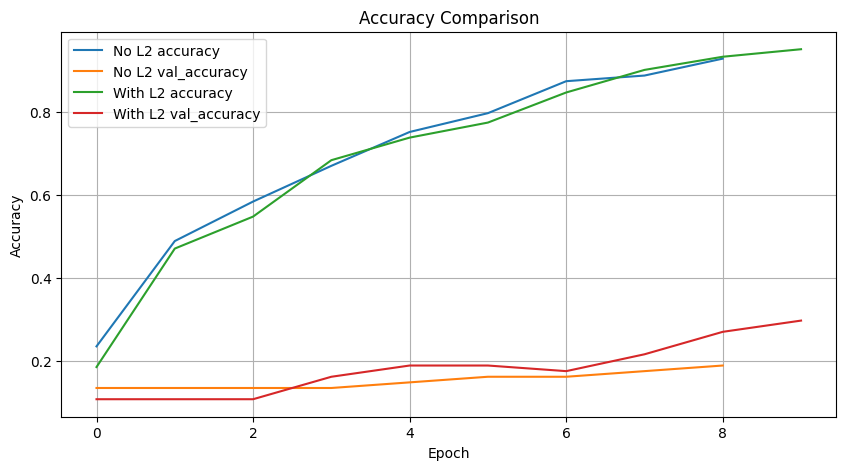

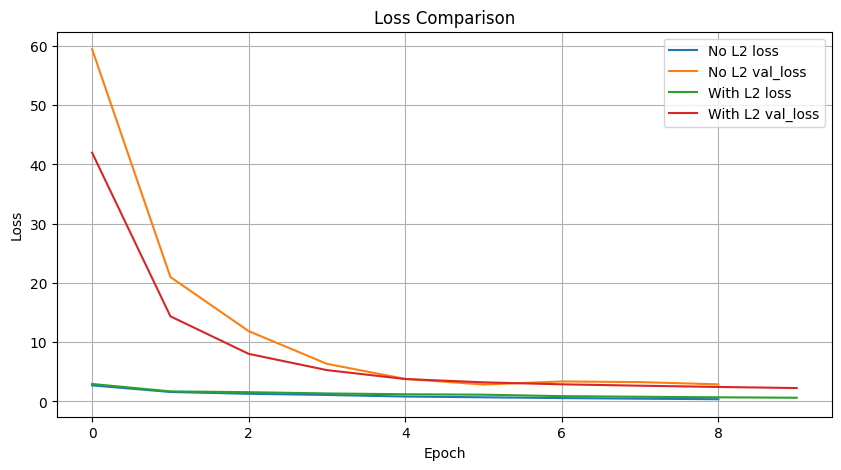

In [26]:
# Rebuild both models
model_no_l2 = build_model_no_l2()
model_l2 = build_model_with_l2()

# Compile both models
model_no_l2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_l2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train baseline model (no L2)
history_no_l2 = model_no_l2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Train L2-regularized model
history_l2 = model_l2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

histories = {
    "No L2": hist_no_l2,
    "With L2": hist_l2
}

plot_history(histories, "accuracy")
plot_history(histories, "loss")

##7: Model Evaluation

In [31]:

def evaluate_both_models(model_no_l2, model_l2, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Comprehensive evaluation of both models on train, validation, and test sets
    """

    # Get predictions for all sets
    # No L2 model
    y_train_pred_no_l2 = model_no_l2.predict(X_train).argmax(axis=1)
    y_val_pred_no_l2 = model_no_l2.predict(X_val).argmax(axis=1)
    y_test_pred_no_l2 = model_no_l2.predict(X_test).argmax(axis=1)

    # L2 model
    y_train_pred_l2 = model_l2.predict(X_train).argmax(axis=1)
    y_val_pred_l2 = model_l2.predict(X_val).argmax(axis=1)
    y_test_pred_l2 = model_l2.predict(X_test).argmax(axis=1)

    # Calculate accuracies
    results = {
        'no_l2': {
            'train_acc': accuracy_score(y_train, y_train_pred_no_l2),
            'val_acc': accuracy_score(y_val, y_val_pred_no_l2),
            'test_acc': accuracy_score(y_test, y_test_pred_no_l2)
        },
        'with_l2': {
            'train_acc': accuracy_score(y_train, y_train_pred_l2),
            'val_acc': accuracy_score(y_val, y_val_pred_l2),
            'test_acc': accuracy_score(y_test, y_test_pred_l2)
        }
    }

    # Print comparison summary
    print("="*80)
    print("MODEL COMPARISON: WITHOUT L2 vs WITH L2 REGULARIZATION")
    print("="*80)

    print("\nACCURACY COMPARISON:")
    print(f"{'Model':<20} {'Train':<15} {'Validation':<15} {'Test':<15} {'Overfit (Train-Test)':<20}")
    print("-"*80)

    # No L2
    overfit_no_l2 = results['no_l2']['train_acc'] - results['no_l2']['test_acc']
    print(f"{'Without L2':<20} {results['no_l2']['train_acc']:<15.4f} "
          f"{results['no_l2']['val_acc']:<15.4f} {results['no_l2']['test_acc']:<15.4f} "
          f"{overfit_no_l2:<20.4f}")

    # With L2
    overfit_l2 = results['with_l2']['train_acc'] - results['with_l2']['test_acc']
    print(f"{'With L2':<20} {results['with_l2']['train_acc']:<15.4f} "
          f"{results['with_l2']['val_acc']:<15.4f} {results['with_l2']['test_acc']:<15.4f} "
          f"{overfit_l2:<20.4f}")

    print("\nIMPROVEMENT WITH L2:")
    print(f"  Test Accuracy Change: {results['with_l2']['test_acc'] - results['no_l2']['test_acc']:+.4f}")
    print(f"  Overfitting Reduction: {overfit_no_l2 - overfit_l2:+.4f}")

    # Detailed classification reports for test set
    print("\n" + "="*80)
    print("TEST SET CLASSIFICATION REPORTS")
    print("="*80)

    print("\nMODEL WITHOUT L2:")
    print(classification_report(y_test, y_test_pred_no_l2))

    print("\nMODEL WITH L2:")
    print(classification_report(y_test, y_test_pred_l2))

    # Plot confusion matrices
    plot_confusion_matrices(y_test, y_test_pred_no_l2, y_test_pred_l2)

    # Plot performance comparison
    plot_performance_comparison(results)

    return results, y_test_pred_no_l2, y_test_pred_l2





In [32]:
def plot_confusion_matrices(y_true, y_pred_no_l2, y_pred_l2):
    """Plot confusion matrices side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion matrix for model without L2
    cm_no_l2 = confusion_matrix(y_true, y_pred_no_l2)
    sns.heatmap(cm_no_l2, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix - No L2 Regularization', fontsize=14)
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Confusion matrix for model with L2
    cm_l2 = confusion_matrix(y_true, y_pred_l2)
    sns.heatmap(cm_l2, annot=True, fmt='d', cmap='Greens', ax=ax2)
    ax2.set_title('Confusion Matrix - With L2 Regularization', fontsize=14)
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
MODEL COMPARISON: WITHOUT L2 vs WITH L2 REGULARIZATION

ACCURACY COMPARISON:
Model                Train           Validation      Test            Overfit (Train-Test)
--------------------------------------------------------------------------------
Without L2           0.9593          0.2973          0.3243          0.6350              
With L2              0.4253          0.1486          0.1757          0.2497              

IMPROVEMENT WITH L2:
  Test Accuracy Change: -0.1486
  Overfitting Reduction: +0.3853

TEST SET CLASSIFICATION REPORTS

MODEL WITHOUT L2:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.20      0.12      0.15         8
           2       0.30      1.00      0.46         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

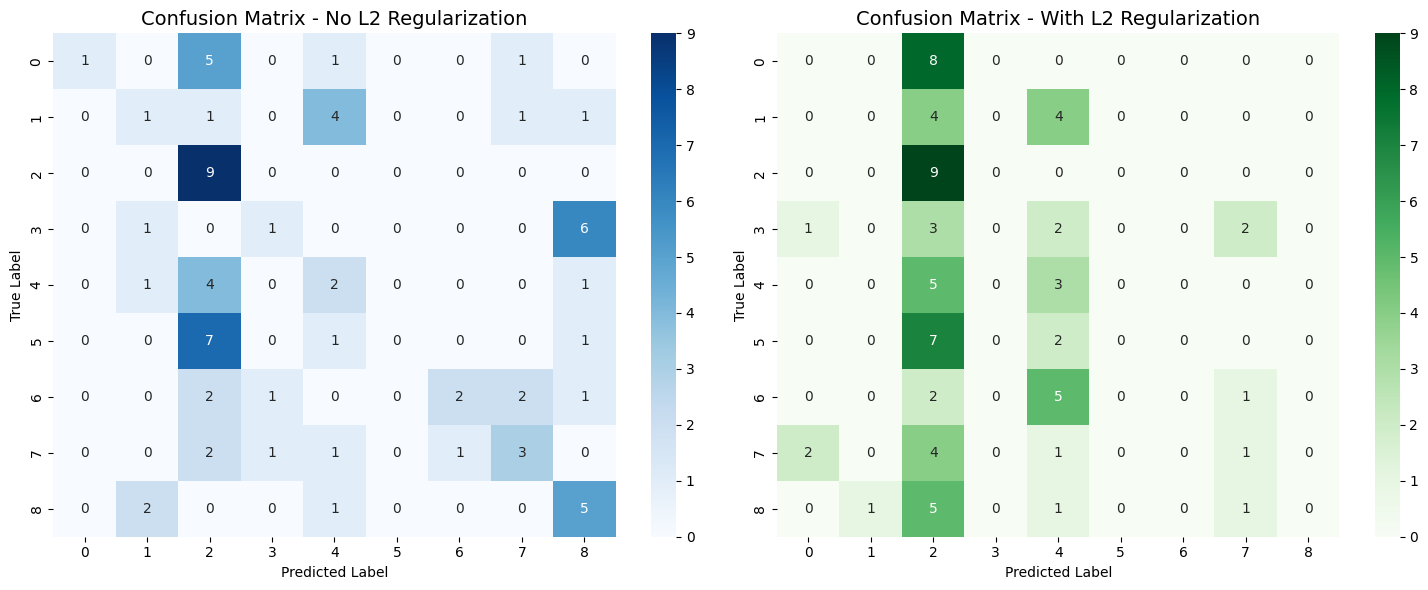

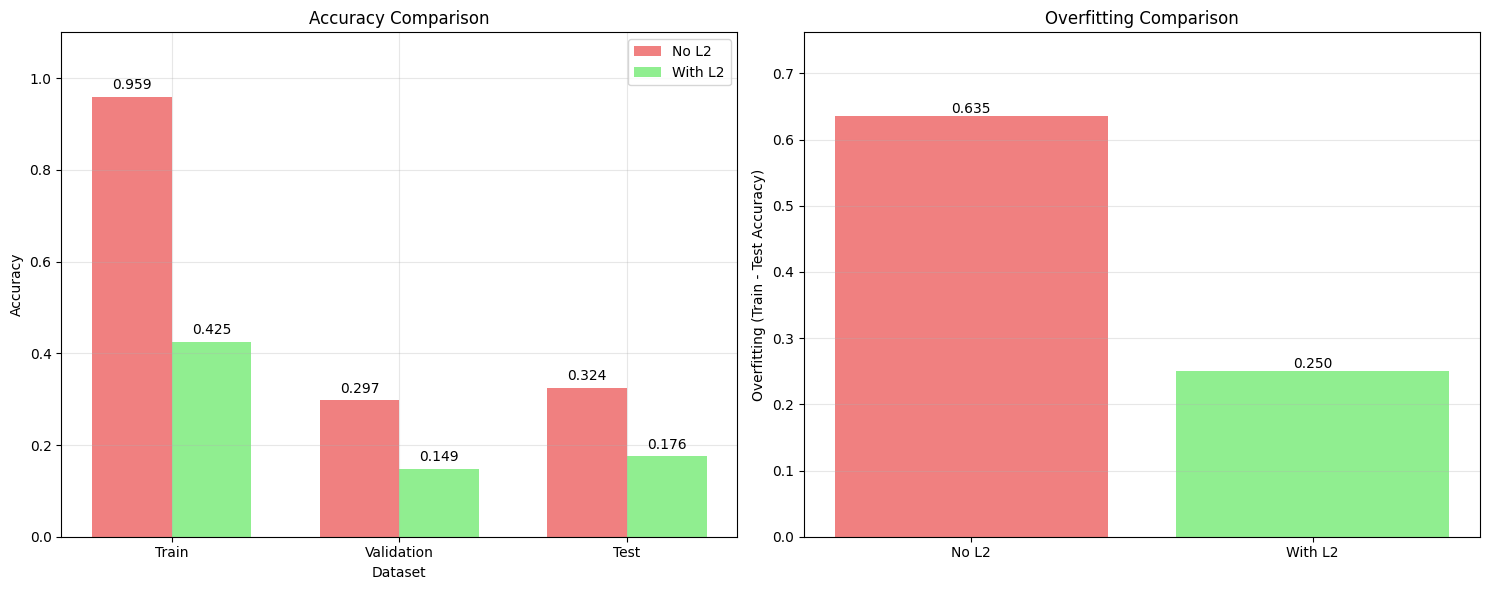

In [33]:
def plot_performance_comparison(results):
    """Plot performance metrics comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    metrics = ['Train', 'Validation', 'Test']
    no_l2_accs = [results['no_l2']['train_acc'],
                  results['no_l2']['val_acc'],
                  results['no_l2']['test_acc']]
    l2_accs = [results['with_l2']['train_acc'],
               results['with_l2']['val_acc'],
               results['with_l2']['test_acc']]

    x = np.arange(len(metrics))
    width = 0.35

    ax1.bar(x - width/2, no_l2_accs, width, label='No L2', color='lightcoral')
    ax1.bar(x + width/2, l2_accs, width, label='With L2', color='lightgreen')
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.set_ylim(0, 1.1)
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(no_l2_accs):
        ax1.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(l2_accs):
        ax1.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # Overfitting comparison
    models = ['No L2', 'With L2']
    overfitting = [
        results['no_l2']['train_acc'] - results['no_l2']['test_acc'],
        results['with_l2']['train_acc'] - results['with_l2']['test_acc']
    ]

    colors = ['lightcoral', 'lightgreen']
    bars = ax2.bar(models, overfitting, color=colors)
    ax2.set_ylabel('Overfitting (Train - Test Accuracy)')
    ax2.set_title('Overfitting Comparison')
    ax2.set_ylim(0, max(overfitting) * 1.2)
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, val in zip(bars, overfitting):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Run the evaluation
results, y_test_pred_no_l2, y_test_pred_l2 = evaluate_both_models(
    model_no_l2, model_l2,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


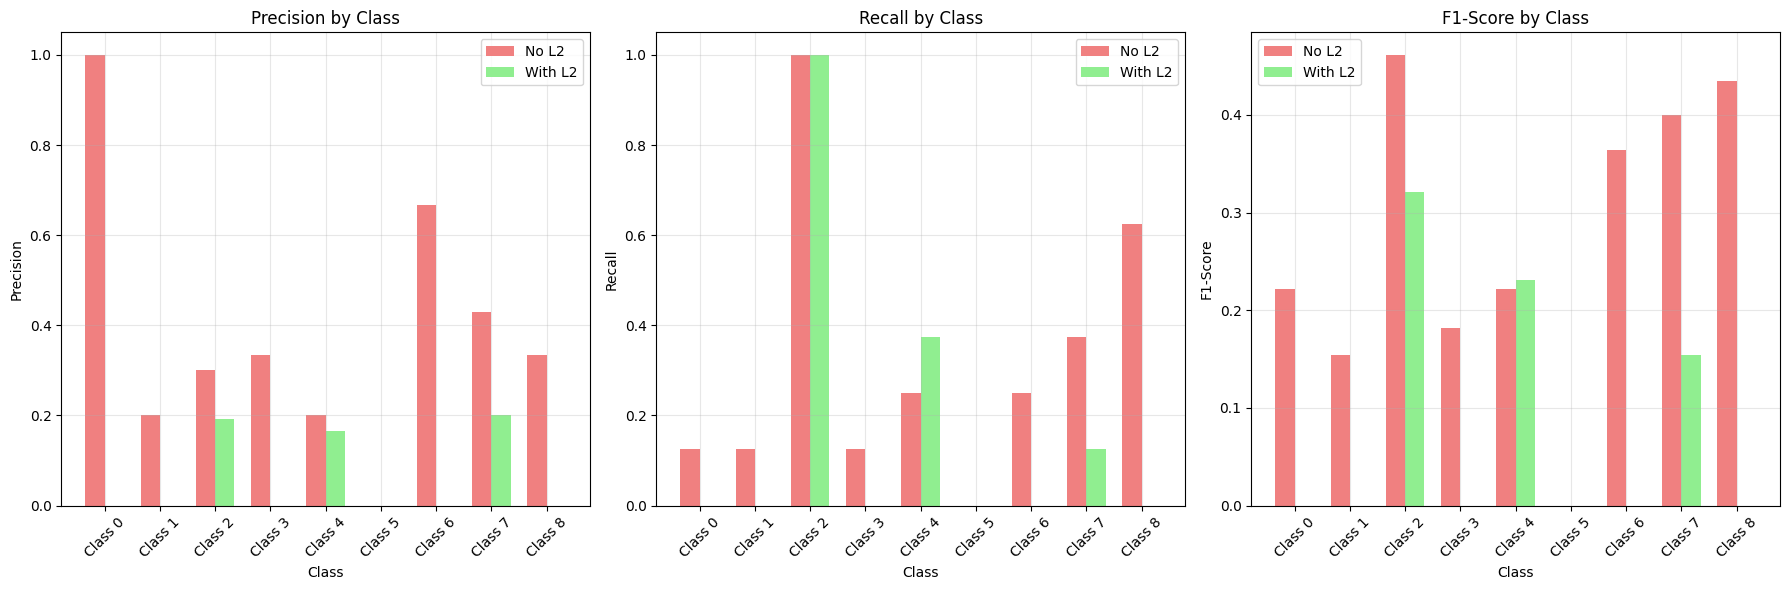

In [34]:
# Additional analysis: Per-class performance comparison
def plot_per_class_comparison(y_true, y_pred_no_l2, y_pred_l2, class_names=None):
    """Compare per-class performance between models"""
    from sklearn.metrics import precision_recall_fscore_support

    # Calculate metrics
    prec_no_l2, rec_no_l2, f1_no_l2, _ = precision_recall_fscore_support(y_true, y_pred_no_l2, average=None)
    prec_l2, rec_l2, f1_l2, _ = precision_recall_fscore_support(y_true, y_pred_l2, average=None)

    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(prec_no_l2))]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    x = np.arange(len(class_names))
    width = 0.35

    # Precision
    axes[0].bar(x - width/2, prec_no_l2, width, label='No L2', color='lightcoral')
    axes[0].bar(x + width/2, prec_l2, width, label='With L2', color='lightgreen')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision by Class')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Recall
    axes[1].bar(x - width/2, rec_no_l2, width, label='No L2', color='lightcoral')
    axes[1].bar(x + width/2, rec_l2, width, label='With L2', color='lightgreen')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Recall')
    axes[1].set_title('Recall by Class')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(class_names, rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1-Score
    axes[2].bar(x - width/2, f1_no_l2, width, label='No L2', color='lightcoral')
    axes[2].bar(x + width/2, f1_l2, width, label='With L2', color='lightgreen')
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score by Class')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(class_names, rotation=45)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_per_class_comparison(y_test, y_test_pred_no_l2, y_test_pred_l2)

In [35]:
# Get predictions for both models
y_pred_no_l2 = np.argmax(model_no_l2.predict(X_test), axis=1)
y_pred_l2 = np.argmax(model_l2.predict(X_test), axis=1)

# Print classification reports for both
print("="*60)
print("MODEL WITHOUT L2 REGULARIZATION")
print("="*60)
print(classification_report(y_test, y_pred_no_l2))

print("\n" + "="*60)
print("MODEL WITH L2 REGULARIZATION")
print("="*60)
print(classification_report(y_test, y_pred_l2))

# Print confusion matrices for both
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

print("\nWithout L2:")
print(confusion_matrix(y_test, y_pred_no_l2))

print("\nWith L2:")
print(confusion_matrix(y_test, y_pred_l2))

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
MODEL WITHOUT L2 REGULARIZATION
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.20      0.12      0.15         8
           2       0.30      1.00      0.46         9
           3       0.33      0.12      0.18         8
           4       0.20      0.25      0.22         8
           5       0.00      0.00      0.00         9
           6       0.67      0.25      0.36         8
           7       0.43      0.38      0.40         8
           8       0.33      0.62      0.43         8

    accuracy                           0.32        74
   macro avg       0.38      0.32      0.27        74
weighted avg       0.38      0.32      0.27        74


MODEL WITH L2 REGULARIZATION
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [36]:
# Get predictions for both models
y_pred_no_l2 = np.argmax(model_no_l2.predict(X_val), axis=1)
y_pred_l2 = np.argmax(model_l2.predict(X_val), axis=1)

# Reverse map from label index to composer name
index_to_label = {v: k for k, v in label_map.items()}

# Get predicted composer names for both models
y_pred_composers_no_l2 = [index_to_label[i] for i in y_pred_no_l2]
y_pred_composers_l2 = [index_to_label[i] for i in y_pred_l2]
y_true_composers = [index_to_label[i] for i in y_val]

# Print sample predictions comparison
print("="*80)
print("SAMPLE PREDICTIONS COMPARISON (First 20)")
print("="*80)
print(f"{'True':<15} | {'No L2 Pred':<15} | {'With L2 Pred':<15} | {'Match'}")
print("-"*80)

for i in range(20):
    true_label = y_true_composers[i]
    pred_no_l2 = y_pred_composers_no_l2[i]
    pred_l2 = y_pred_composers_l2[i]

    # Check which predictions are correct
    match_no_l2 = "✓" if true_label == pred_no_l2 else "✗"
    match_l2 = "✓" if true_label == pred_l2 else "✗"
    match_status = f"{match_no_l2} | {match_l2}"

    print(f"{true_label:<15} | {pred_no_l2:<15} | {pred_l2:<15} | {match_status}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
SAMPLE PREDICTIONS COMPARISON (First 20)
True            | No L2 Pred      | With L2 Pred    | Match
--------------------------------------------------------------------------------
mendelssohn     | handel          | handel          | ✗ | ✗
handel          | mozart          | byrd            | ✗ | ✗
mozart          | byrd            | byrd            | ✗ | ✗
bach            | byrd            | byrd            | ✗ | ✗
chopin          | chopin          | hummel          | ✓ | ✗
handel          | mendelssohn     | bach            | ✗ | ✗
bach            | bach            | byrd            | ✓ | ✗
hummel          | mendelssohn     | byrd            | ✗ | ✗
handel          | byrd            | byrd            | ✗ | ✗
byrd            | byrd            | byrd            | ✓ | ✓
schumann        | mendelssohn     | handel          | ✗ | ✗
mozart          | schumann        | byrd            | ✗ | ✗
mendelssohn     | byrd    